In [3]:
# import Pkg;
# Pkg.add("CSV"); 
# Pkg.add("DataFrames");

In [4]:
using CSV
using DataFrames
using LinearAlgebra
using Plots

In [5]:
function get_actual_values_from_cumulatives(cumulative_vector)
    shifted_values = zeros(Float64, size(cumulative_vector)[1]+1)
    for (index, value) in enumerate(cumulative_vector)
       shifted_values[index+1] = value  
    end

    final_values = zeros(Float64, size(cumulative_vector)[1])
    for (index, value) in enumerate(cumulative_vector)
       final_values[index] = -shifted_values[index]+cumulative_vector[index]  
    end
    return final_values
end

get_actual_values_from_cumulatives (generic function with 1 method)

Read data. Data downloaded from https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

**Note: recovered data for US  available only until Dec 13, 2020**

In [6]:
infected_cases_data_path = "data/countries/time_series_covid19_confirmed_global.csv"
recovered_cases_data_path = "data/countries/time_series_covid19_recovered_global.csv"
deceased_cases_data_path = "data/countries/time_series_covid19_deaths_global.csv"

infected_total = CSV.read(infected_cases_data_path, DataFrame)
infected_US = infected_total[infected_total[!, :"Country/Region"] .== "US", :]
infected = select(infected_US, Not([:"Province/State", :"Lat", :"Long", :"Country/Region"])) #remove columns that are not required

recovered_total = CSV.read(recovered_cases_data_path, DataFrame)

recovered_US = recovered_total[recovered_total[!, :"Country/Region"] .== "US", :]
recovered = select(recovered_US, Not([:"Province/State", :"Lat", :"Long", :"Country/Region"])) #remove columns that are not required


deceased_total = CSV.read(deceased_cases_data_path, DataFrame)
deceased_US = deceased_total[deceased_total[!, :"Country/Region"] .== "US", :]
deceased = select(deceased_US, Not([:"Province/State", :"Lat", :"Long", :"Country/Region"]))#remove columns that are not required


# #convert to matrices

infected = Matrix(infected)'[1:327]
recovered = Matrix(recovered)'[1:327] #considering only until Dec 13 2020.
deceased = Matrix(deceased)'[1:327]

# infected = get_actual_values_from_cumulatives(infected)
# recovered = get_actual_values_from_cumulatives(recovered)
# deceased = get_actual_values_from_cumulatives(deceased)

327-element Vector{Int64}:
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      ⋮
 276209
 279178
 281790
 284180
 285583
 287142
 289725
 292906
 295892
 299273
 301806
 303465

Algorithm:

Equations:
    I(t) = αĨ(t)

    R(t) = αR̃(t)

    S(t) = αS̃(t)

where I(t), R(t) and S(t) are the actual number of infected, recovered and susceptible population at time t and α≥1;
   
    S(t₀) = ωP

where ωϵ[0,1] and P is the total population.

S̃(t + 1) = S̃(t) - β * (S̃(t) * Ĩ(t)) ÷ (S̃(t) + Ĩ(t))
Ĩ(t + 1) = Ĩ(t) + β * (S̃(t) * Ĩ(t)) ÷ (S̃(t) + Ĩ(t)) - γ * Ĩ(t) - ν * Ĩ(t)
R̃(t + 1) = R̃(t) + γ * Ĩ(t)
D(t + 1) = D(t) + α * ν * Ĩ(t)

where
    I(t) = αĨ(t)

    R(t) = αR̃(t)

    S(t) = αS̃(t)

where I(t), R(t) and S(t) are the actual number of infected, recovered and susceptible population at time t and α≥1;
   
    S(t₀) = ωP

where ωϵ[0,1] and P is the total population.

    S̃(t) = (ω ÷ α) * P - Ĩ(t) - R̃(t) - D̃(t)

    Δ(t) = [Ĩ(t + 1)-Ĩ(t); R̃(t + 1)-R̃(t); D̃(t + 1)-D̃(t)]
    Δ(t) = Φ_ωα(t) = [S̃(t)-β*(S̃(t)*Ĩ(t))÷(S̃(t)+Ĩ(t)) -Ĩ(t) -Ĩ(t)÷α; 0 Ĩ(t) 0; 0 0 Ĩ(t)]
    
    Δ̄ = [ρ^(Θ -t₀)Δ(t₀); ρ^(Θ -t₀-1)Δ(t₀+1); ρ^(Θ -t₀-2)Δ(t₀+2)...Δ(Θ)]
    Φ̄_ωα = [ρ^(Θ -t₀)Φ_ωα(t₀); ρ^(Θ -t₀-1)Φ_ωα(t₀+1); ρ^(Θ -t₀-2)Φ_ωα(t₀+2)...Φ_ωα(Θ)]

where ρϵ(0,1)


Steps:
1. Input: data Ĩ(t), R̃(t), and D(t), maximum value ᾱ of α, weighting parameter ρ, and total population P

outputs -> ω⋆, α⋆, β⋆, γ⋆, ν̄⋆


In [64]:
#we have Ĩ(t) and R̃(t) and D(t) in infected, recovered and deceased dataframes.
P = 332902734 #https://www.census.gov/popclock/
ᾱ = 10       # ᾱ*Infected + ᾱ*Recovered + ᾱ*Deceased < ω*Population
ρ = 1
ω = 0.01 
α_0 = 1
α_increment = 0.1
ω_increment = 0.01

num_α = Int64((ᾱ-α_0)/α_increment)+1
num_ω = Int64((1/ω_increment))

100

In [8]:
function get_susceptible(ω, α, P, Ĩ, R̃, D)
    population = zeros(Float64, size(Ĩ)[1])
    fill!(population, ω*P/α)
    return population-infected-recovered-deceased
end

get_susceptible (generic function with 1 method)

In [9]:
function invalid(vector_values)
    for (index, value) in enumerate(vector_values)
        if value < 1
            return true
        end
    end
    return false
end

invalid (generic function with 1 method)

In [10]:
function computeΔ̄(Ĩ, R̃, D, ρ)
    Θ = size(Ĩ)[1]
    
    ρmatrix = zeros(Float64, Θ)
    for i in 1:Θ
        power = Θ-i
        ρmatrix[i] = ρ^power
    end
    
    Δ̄ = zeros(Float64, 3Θ)
    for i in 1:Θ-1
        Δ̄[3(i-1)+1] = ρmatrix[i]*(Ĩ[i+1]-Ĩ[i])
        Δ̄[3(i-1)+2] = ρmatrix[i]*(R̃[i+1]-R̃[i])
        Δ̄[3(i-1)+3] = ρmatrix[i]*(D[i+1]-D[i])
    end
    
    Δ̄[3(Θ-1)+1] = ρmatrix[Θ]*(Ĩ[Θ])
    Δ̄[3(Θ-1)+2] = ρmatrix[Θ]*(R̃[Θ])
    Δ̄[3(Θ-1)+3] = ρmatrix[Θ]*(D[Θ])

    return Δ̄
end

computeΔ̄ (generic function with 1 method)

In [11]:
function computeΦ(ω, α, S̃, Ĩ)
    Θ = size(Ĩ)[1]
    
    ρmatrix = zeros(Float64, Θ)
    for i in 1:Θ
        power = Θ-i
        ρmatrix[i] = ρ^power
    end
    
    Φ = zeros(Float64, 3*Θ, 3)
    i=1
    while i<Θ
        Φ[i] = ρmatrix[i]*(S̃[i]*Ĩ[i])/ (S̃[i]+Ĩ[i])
        Φ[3*Θ+i] = -1*ρmatrix[i]*Ĩ[i]
        Φ[6*Θ+i] = -1*ρmatrix[i]*Ĩ[i]/α
        Φ[i+1] = 0
        Φ[3*Θ+i+1] = ρmatrix[i]*Ĩ[i]
        Φ[6*Θ+i+1] = 0
        Φ[i+2] = 0
        Φ[3*Θ+i+2] = 0
        Φ[6*Θ+i+2] = ρmatrix[i]*Ĩ[i]
        i+=3
    end
    return Φ
    
end

# S̃ = get_susceptible(0.5, 2, P, infected, recovered, deceased)
# computeΦ(0.5, 2, S̃, infected)


computeΦ (generic function with 1 method)

In [13]:
function computeParameters(Φ̄, Δ̄)
    pseudo_inv = pinv(Φ̄)
    params = pseudo_inv * Δ̄
    return params
end

computeParameters (generic function with 1 method)

In [14]:
function error_(Δ̄, Φ̄, params)
    param_matrix = zeros(Float64, 3, 1)
    param_matrix[1] = params[1]
    param_matrix[2] = params[2]
    param_matrix[3] = params[3]
    
    diff = Δ̄-(Φ̄*param_matrix)
    return norm(diff)^2
end

# M = [1.5 1.3; 1.2 1.9]
# N = [2,4]
# params = computeParameters(M, N)
# error_(N, M, params)
# # print(params)


error_ (generic function with 1 method)

In [67]:
function sir_model(Ĩ, R̃, D, P, ᾱ, ρ)
    e = Inf
    Δ̄ = computeΔ̄(Ĩ, R̃, D, ρ)
    ω_ = Inf
    α_ = Inf
    β_ = Inf
    γ_ = Inf
    ν̃_ = Inf
    
    ω = 0.01 
    α_0 = 1
    α_increment = 0.1
    ω_increment = 0.01
    
    num_α = Int64((ᾱ-α_0)/α_increment)+1
    num_ω = Int64((1/ω_increment))
    num_solve_points = (num_α*num_ω)
    loss_vals = zeros(Float64, num_ω, num_α)
    
    ω_store = zeros(Float64, num_ω, num_α)
    α_store = zeros(Float64, num_ω, num_α)
    β_store = zeros(Float64, num_ω, num_α)
    γ_store = zeros(Float64, num_ω, num_α)
    ν̃_store = zeros(Float64, num_ω, num_α)
    
    i = j = 1
    while ω ≤ 1
        α = α_0
        j=1
        while α ≤ ᾱ
            S̃ = get_susceptible(ω, α, P, Ĩ, R̃, D)
            if invalid(S̃)
                ω_store[i,j] = ω
                α_store[i,j] = α
                β_store[i,j] = 0
                γ_store[i,j] = 0
                ν̃_store[i,j] = 0
                loss_vals[i,j] = 0
                α+=α_increment
                j+=1
                continue
            end
            
            Φ̄ = computeΦ(ω, α, S̃, Ĩ)
            params = computeParameters(Φ̄, Δ̄)
            β = params[1]
            γ = params[2]
            ν̃ = params[3]
            if(β<0 || γ<0 || ν̃<0)
                ω_store[i,j] = ω
                α_store[i,j] = α
                β_store[i,j] = 0
                γ_store[i,j] = 0
                ν̃_store[i,j] = 0
                loss_vals[i,j] = 0
                α+=α_increment
                j+=1
                continue
            end

            error_value = error_(Δ̄, Φ̄, params)
            if error_value < e
                e = error_value
                ω_ = ω
                α_ = α
                β_ = β
                γ_ = γ
                ν̃_ = ν̃
            end

            ω_store[i,j] = ω
            α_store[i,j] = α
            β_store[i,j] = β
            γ_store[i,j] = γ
            ν̃_store[i,j] = ν̃
            loss_vals[i,j] = error_value
            
            α+=α_increment
            j+=1
        end
        ω+=ω_increment
        i+=1
    end
    return ω_, α_, β_, γ_, ν̃_, e, ω_store, α_store, β_store, γ_store, ν̃_store, loss_vals
end

sir_model (generic function with 1 method)

In [68]:
ω_, α_, β_, γ_, ν̃_, least_loss, ω_store, α_store, β_store, γ_store, ν̃_store, loss_vals = sir_model(infected, recovered, deceased, P, ᾱ, ρ)

(0.8600000000000005, 9.199999999999985, 0.0055204275235139835, 0.0005374202009174701, 0.0001825507454755636, 3.1299054703385944e14, [0.01 0.01 … 0.01 0.01; 0.02 0.02 … 0.02 0.02; … ; 0.9900000000000007 0.9900000000000007 … 0.9900000000000007 0.9900000000000007; 0.0 0.0 … 0.0 0.0], [1.0 1.1 … 9.899999999999983 9.999999999999982; 1.0 1.1 … 9.899999999999983 9.999999999999982; … ; 1.0 1.1 … 9.899999999999983 9.999999999999982; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.00367149437022752 0.003667684477100393 … 0.005332803047245532 0.0053595242995487635; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0005498395684616228 0.0005508171806683391 … 0.0005605719562924862 0.0005577375506949395; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.00019255191990789685 0.00019255826983824505 … 0.0001849101582527673 0.00018460607258123074; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 3.129931832263481e14 3.129931564003595e14 … 3.12

In [28]:
function meshgrid(xin,yin)
    nx=length(xin)
    ny=length(yin)
    xout=zeros(ny,nx)
    yout=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            xout[ix,jx]=xin[jx]
            yout[ix,jx]=yin[ix]
        end
    end
    return (x=xout, y=yout)
end

meshgrid (generic function with 1 method)

In [70]:
function plot_loss_curve(ω_, α_, β_, γ_, ν̃_, least_loss, ω_store, α_store, β_store, γ_store, ν̃_store, loss_vals)
    # ω_s,α_s = meshgrid(vec(ω_store), vec(α_store))
    PyPlot.plot_surface(reshape(vec(ω_store),(num_ω,num_α)), reshape(vec(α_store),(num_ω,num_α)), reshape(vec(loss_vals),(num_ω,num_α)))
    # plot(x, y, z, zcolor = reverse(z), m = (10, 0.8, :blues, Plots.stroke(0)), leg = false, cbar = true, w = 5)
    # scatter!(ω_, α_, least_loss, w = 10)
end

plot_loss_curve (generic function with 1 method)

In [60]:
function plot_loss_tri(ω_, α_, β_, γ_, ν̃_, least_loss, ω_store, α_store, β_store, γ_store, ν̃_store, loss_vals)
    # ω_s,α_s = meshgrid(vec(ω_store), vec(α_store))
    PyPlot.plot_trisurf(vec(ω_store), vec(α_store), vec(loss_vals))
    # plot(x, y, z, zcolor = reverse(z), m = (10, 0.8, :blues, Plots.stroke(0)), leg = false, cbar = true, w = 5)
    # scatter!(ω_, α_, least_loss, w = 10)
end

plot_loss_tri (generic function with 1 method)

In [18]:
println(typeof(vec(ω_store)),size(vec(α_store)),size(vec(loss_vals)))

Vector{Float64}(740,)(740,)


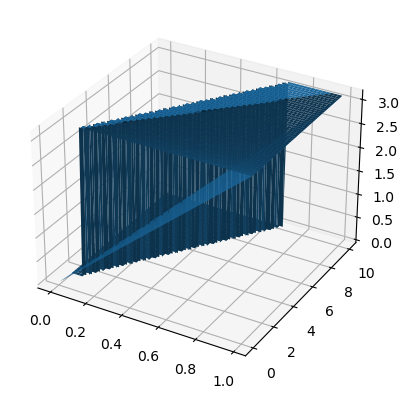

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7f2d83d83760>

In [71]:
pyplot()
plot_loss_curve(ω_, α_, β_, γ_, ν̃_, least_loss, ω_store, α_store, β_store, γ_store, ν̃_store, loss_vals)

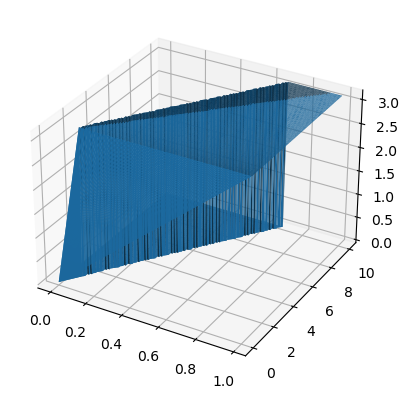

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7f2d839e9370>

In [72]:
plot_loss_tri(ω_, α_, β_, γ_, ν̃_, least_loss, ω_store, α_store, β_store, γ_store, ν̃_store, loss_vals)

In [20]:
pyplot()
Plots.PyPlotBackend()

Plots.PyPlotBackend()

In [21]:
function store_data(infected_df,recovered_df,deceased_df)
    infected_cases_data_path = "data/preprocessed/countries/time_series_covid19_confirmed_global.csv"
    recovered_cases_data_path = "data/preprocessed/countries/time_series_covid19_recovered_global.csv"
    deceased_cases_data_path = "data/preprocessed/countries/time_series_covid19_deaths_global.csv"

    CSV.write(infected_cases_data_path, infected_df)
#     infected_US = infected_total[infected_total[!, :"Country/Region"] .== "US", :]
#     infected = select(infected_US, Not([:"Province/State", :"Lat", :"Long", :"Country/Region"])) #remove columns that are not required

    CSV.write(recovered_cases_data_path, recovered_df)
#     recovered_US = recovered_total[recovered_total[!, :"Country/Region"] .== "US", :]
#     recovered = select(recovered_US, Not([:"Province/State", :"Lat", :"Long", :"Country/Region"])) #remove columns that are not required

    CSV.write(deceased_cases_data_path, deceased_df)
#     deceased_US = deceased_total[deceased_total[!, :"Country/Region"] .== "US", :]
#     deceased = select(deceased_US, Not([:"Province/State", :"Lat", :"Long", :"Country/Region"]))#remove columns that are not required


end

store_data (generic function with 1 method)

In [22]:
#compute S̃, Ĩ and R̃ of all time t.


# if !isfile("storage/preprocessed_data.csv")
#     for t = 1:length(infected_total)
#         S̃[t] = [ω / α] * P - Ĩ[t] - R̃[t] - D̃[t]
#         Ĩ[t + 1] = Ĩ[t] + β * [[S̃[t] * Ĩ[t]] / [S̃[t] + Ĩ[t]]] - γ * Ĩ[t] - ν * Ĩ[t]
#         R̃[t + 1] = R̃[t] + γ * Ĩ[t]
#         D[t + 1] = D[t] + α * ν * Ĩ[t]
#     store_data(infected_df,recovered_df,deceased_df)
# end

# Store to avoid repeated computing.

In [239]:
using AutoGrad
using ForwardDiff
using StaticArrays
using SciPy
using Random,Distributions
using Plots
Random.seed!(19920908);

In [240]:
function g(S,I,t,theta)
    ds = -theta*S*I
    di = theta*S*I - I
    
    return [ds,di]
end

g (generic function with 2 methods)

In [241]:
function ODESYS(Y,t,theta)

    #Y will be length 4.
    #Y[0], Y[1] are the ODEs
    #Y[2], Y[3] are the sensitivities
    x = [Y[1],Y[2],t,theta]
    #ODE
    dy_dt = g(x[1],x[2],x[3],x[4])
    #Sensitivities
    J = ForwardDiff.jacobian(x->g(x[1],x[2],x[3],x[4]),x)
    grad_y_theta = J[:,1:2]Y[3:4]+J[:,4]
    # println(J[:,1:2]Y[3:4],J[:,4])
    
    return vcat(dy_dt,grad_y_theta)
end

ODESYS (generic function with 1 method)

In [255]:
    
function Cost(y_obs, Y)
    # Squared Error Loss
    n = size(Y)[1]
    err = norm(y_obs - Y)
    # print(err)
    return sum(err)/n
end

# np.random.seed(19920908)
## Generate Data
#Initial Condition
Y0 = [0.99,0.01, 0.0, 0.0]
#Space to compute solutions
t = LinRange(0,5,101)
#True param value
theta = 5.5
# ODESYS(Y0,theta)
sol = SciPy.integrate.odeint(ODESYS, y0 = Y0,t=t, args = tuple(theta))
#Corupt the observations with noise
d=Normal(0,0.05)
s = size(sol[:,1:2])
# println(rand(d,s))
random_vals = [ 0.01693986 -0.06596811;
 0.06068807 -0.03013196;
 0.02848613 -0.00566862;
 0.00623309  0.02766387;
-0.0044235   0.01530301;
 0.00876406  0.10901152;
-0.02647777  0.05888131;
-0.03228174  0.0754864 ;
 0.03039854  0.00315062;
-0.02286297  0.06553415;
-0.05293991  0.03360738;
-0.0097122   0.00687125;
-0.00354927  0.03322753;
 0.07143109 -0.03000927;
 0.04453561  0.04967233;
-0.00334528 -0.0640557 ;
-0.01798205 -0.04571463;
 0.02176416  0.02789819;
-0.02176861 -0.04291397;
-0.0609574   0.11242536;
-0.01834849 -0.09106916;
 0.01247497  0.05269345;
-0.09944109 -0.07302471;
 0.017326    0.00149685;
-0.05645482 -0.00431103;
 0.02973477  0.10183735;
-0.01054309 -0.07818884;
-0.04608416  0.11265981;
 0.05216003  0.02819208;
-0.0650253  -0.07106277;
-0.08251391  0.00413041;
 0.02202625  0.03078285;
 0.02411218 -0.01665187;
 0.03236185 -0.04798279;
 0.04527003 -0.09034922;
 0.1167077   0.1496083 ;
 0.01398873  0.01416904;
 0.08779887  0.08729583;
 0.06622838  0.01048809;
-0.15858365 -0.02261626;
 0.03319149  0.09747788;
-0.02821547  0.05775099;
 0.01421325  0.0640098 ;
 0.08222257 -0.06445226;
 0.0122565   0.01177445;
 0.0347866  -0.12371159;
-0.13337525  0.01228837;
 0.00455502 -0.01518596;
-0.07367777  0.05868144;
-0.04130576  0.05875552;
-0.06214232  0.0756491 ;
 0.03636876  0.0158407 ;
-0.03750791 -0.00162667;
-0.01908869  0.05691681;
 0.03214129 -0.07294629;
 0.02547832 -0.0370624 ;
 0.02197435  0.08876884;
 0.13502266 -0.01747632;
-0.0320551   0.0934164 ;
-0.09026642  0.0127882 ;
 0.03450163 -0.02490652;
 0.01327181  0.05033872;
 0.03227267  0.03935833;
-0.00365149  0.04656038;
 0.01941274  0.03288452;
-0.03842168  0.02182971;
 0.01081063 -0.07709442;
-0.10346782  0.01429225;
-0.04481337  0.01462979;
-0.03717377 -0.02087199;
-0.02690088 -0.10043567;
 0.01265114 -0.00387117;
-0.03102719 -0.05858558;
-0.03145101  0.07964216;
 0.04617859 -0.07723391;
-0.06992481 -0.0102281 ;
 0.04313553  0.00592475;
-0.00410284 -0.02401807;
 0.02438585  0.03352003;
 0.05222654  0.05288221;
-0.01754562  0.06255184;
 0.09587386  0.00533866;
-0.02348378 -0.00171114;
 0.02411973 -0.05518219;
 0.07621899  0.11317736;
-0.05214113 -0.07532093;
 0.0708475  -0.05469253;
-0.04877625  0.0118769 ;
 0.00530669 -0.02364656;
-0.01298184  0.07266864;
-0.03842064 -0.05331146;
-0.02789867  0.03266142;
 0.03882276 -0.00098766;
-0.01171899  0.10175909;
 0.04928941 -0.01267729;
-0.07486694 -0.1144491 ;
-0.08097267 -0.01890213;
-0.00663317  0.0736906 ;
-0.00415513  0.00404848;
-0.0730351   0.02504463;
 0.00041137 -0.02297239;]
y_obs = sol[:,1:2] .+ random_vals
println("Done")
println(y_obs)
# println(sol[1:3,1:2])


Done
[1.00693986 -0.055968109999999995; 1.047644424051087 -0.017648155276268913; 1.0116577592839788 0.009901342903307596; 0.9847074174583349 0.04706037939481727; 0.9682346535769942 0.03943171674720965; 0.9742416905904461 0.13897352167488414; 0.9301667904048737 0.096005285506083; 0.913544872809354 0.12136056791175769; 0.9630478072945665 0.059651213239344275; 0.8938402387483884 0.13484526513420003; 0.8446194410839408 0.11822516680555617; 0.8650816864419753 0.10958341965452136; 0.8444756779105415 0.15705804926711603; 0.888392072741955 0.11809999376508748; 0.8259932297042549 0.22520669972140345; 0.738230910494677 0.14183591593324116; 0.6796504106602539 0.19301426094132165; 0.6719858589051835 0.30124165656371715; 0.5784388208434222 0.2658913869067751; 0.48771020272188054 0.4564464504489457; 0.4784540757571848 0.28676240171512096; 0.45829551019131326 0.46182045403861083; 0.29738232288807653 0.36393121646038107; 0.3680412501329704 0.4621033512691013; 0.2516934976829076 0.47533632972783996; 0.

In [243]:


# scatter(t,y_obs[:,1], marker = '.', alpha = 0.5, label = 'S')
# scatter!(t,y_obs[:,2], marker = '.', alpha = 0.5, label = 'I')

println("Done")
# .legend()


Done


In [258]:

theta_iter = 1.5
Y = sol[:,1:2]
# cost = Cost(Y, y_obs[:,1:2])
grad_C = AutoGrad.grad(Cost)
# println
maxiter = 100
learning_rate = 1 #Big steps
# sol = SciPy.integrate.odeint(ODESYS,y0 = Y0, t = t, args = tuple(theta))

true_vals = y_obs
print(grad_C(sol[:,1:2],y_obs)[1:3,:])
println(true_vals[1:3,:])
# println(sol[1:3,1:2])

[-0.00021490426870696204 0.0008368917120643558; -0.0007699075023398648 0.00038226330256020197; -0.00036138379750136416 7.191385499512186e-5][1.00693986 -0.055968109999999995; 1.047644424051087 -0.017648155276268913; 1.0116577592839788 0.009901342903307596]


-25.530922357695466
-26.40544040891074
-27.27997361981365
-28.154521051096033
-29.029081846611327
-29.903655223894933
-30.778240465907896
-31.652836914048592
-32.527443961857664
-33.4020610498048


┌ Warning: Skipped marker arg ..
└ @ Plots /home/swish-coder/.julia/packages/Plots/Di0Qb/src/args.jl:1189
┌ Warning: Skipped marker arg ..
└ @ Plots /home/swish-coder/.julia/packages/Plots/Di0Qb/src/args.jl:1189


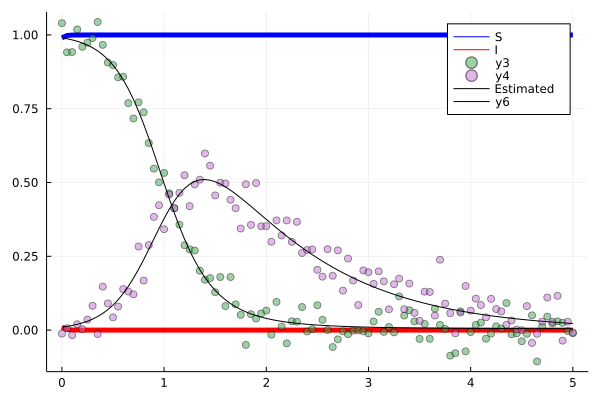

In [249]:
# println((grad_C(Y)*sol[:,s[2]-1:s[2]]).sum())
# theta_iter -=learning_rate*(grad_C(Y)*sol[:,s[2]-1:s[2]]).sum()
for i in 1:maxiter
    sol = SciPy.integrate.odeint(ODESYS,y0 = Y0, t = t, args = tuple(theta_iter))

    Y = sol[:,1:2]
    idx = s[2]-1
    theta_iter -=learning_rate*sum((grad_C(Y,true_vals).*sol[:,s[2]-1:s[2]]))
    if i%10==0
        println(theta_iter)
    end
end


sol = SciPy.integrate.odeint(ODESYS, y0 = Y0, t = t, args = tuple(theta_iter))
true_sol = SciPy.integrate.odeint(ODESYS, y0 = Y0, t = t, args = tuple(theta))


plot(t,sol[:,1], label = "S", color = "blue", linewidth = 5)
plot!(t,sol[:,2], label = "I", color = "red", linewidth = 5)

scatter!(t,y_obs[:,1], marker = ".", alpha = 0.5)
scatter!(t,y_obs[:,2], marker = ".", alpha = 0.5)


plot!(t,true_sol[:,1], label = "Estimated ", color = "black")
plot!(t,true_sol[:,2], color = "black")

# plt.legend()
# plt.show()
